In [6]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime as dt

from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,LabelEncoder,OneHotEncoder,OrdinalEncoder,MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
from scipy.stats import pearsonr, spearmanr, shapiro
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2

from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer


from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Saving Python objects
import pickle

In [7]:
df = pd.read_csv('./Dataset/cardekho.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


In [3]:
df = df.drop_duplicates().reset_index(drop=True)
cat_cols = []
num_cols = []

for i in df.columns:
    # print(str(df[i].dtype))
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print(f'Categorical: {cat_cols}')
print(f'Numeric: {num_cols}')

df['max_power'] = df['max_power'].str.strip().replace({'':np.nan}).astype('float')
cat_cols.remove('max_power')
num_cols.append('max_power')

Categorical: ['name', 'fuel', 'seller_type', 'transmission', 'owner', 'max_power']
Numeric: ['year', 'selling_price', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'seats']


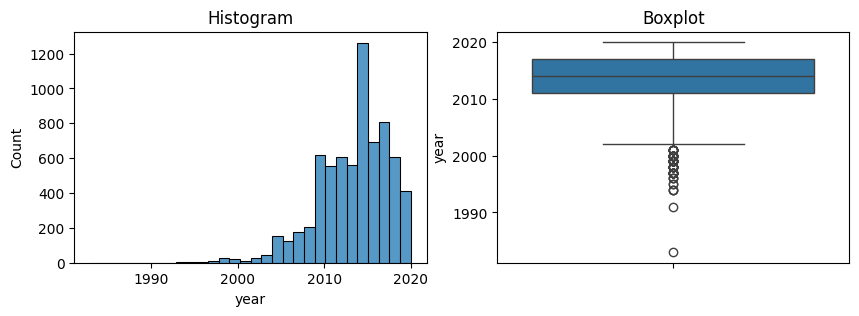

Skewness: -1.0109238235669904
Kurtosis: 1.614733878541498


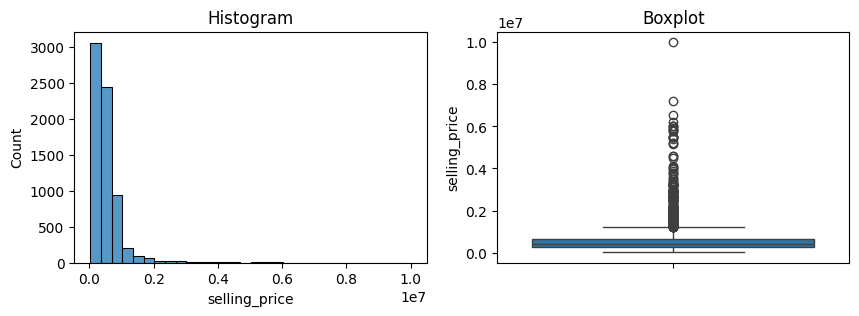

Skewness: 5.572742292649192
Kurtosis: 52.82276601297473


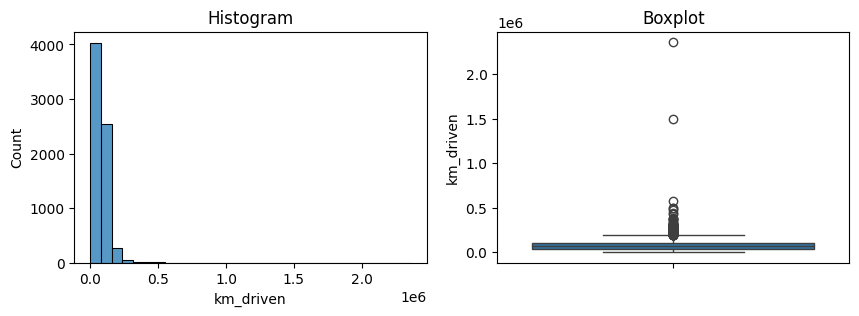

Skewness: 11.758425539599084
Kurtosis: 394.08811938521194


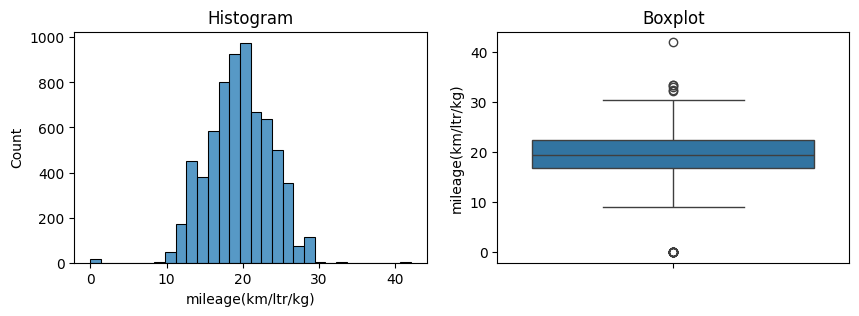

Skewness: -0.1675292102721837
Kurtosis: 0.607895308158489


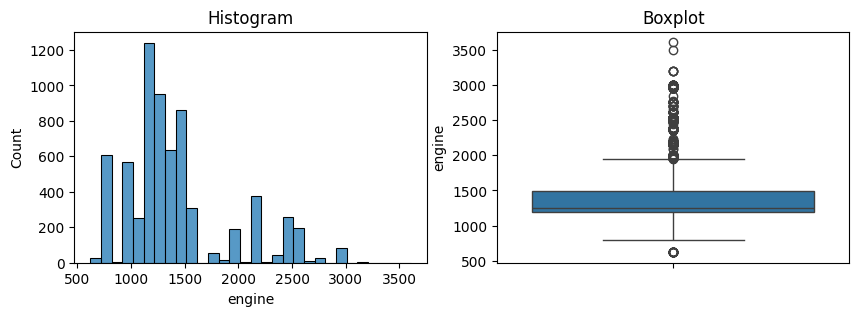

Skewness: 1.2156294419713174
Kurtosis: 0.9696204342567789


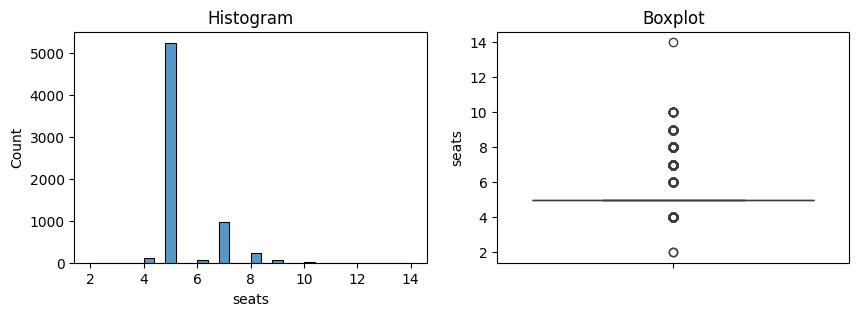

Skewness: 1.9180198914401083
Kurtosis: 3.5997410676759816


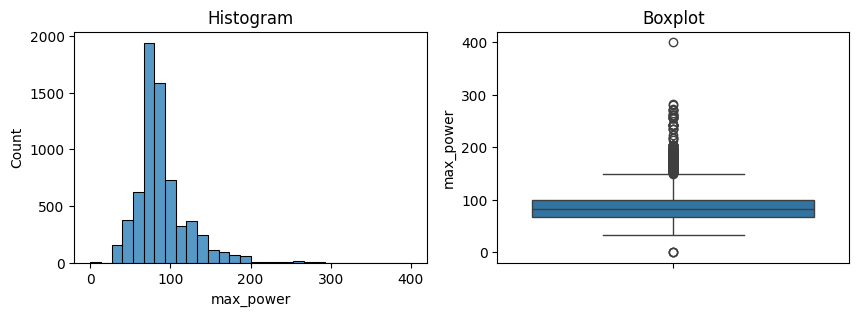

Skewness: 1.6972585962276057
Kurtosis: 5.407685767107205


In [96]:
def check_distribution_outliers(df, columns):
    for col in columns:
        plt.figure(figsize=(10, 3))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30)
        plt.title('Histogram')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title('Boxplot')

        plt.show()

        print('Skewness:', df[col].skew())
        print('Kurtosis:', df[col].kurt())

check_distribution_outliers(df[num_cols], num_cols)

In [4]:
df['age'] = dt.now().year - df['year']
df = df.drop(columns=['year'])

num_cols[0] = 'age'
num_cols.remove('selling_price')

In [12]:
df[df['mileage(km/ltr/kg)'].isna()][['engine','seats']].isna().sum()

engine    208
seats     208
dtype: int64

In [14]:
208/len(df)

0.03003176436615651

In [17]:
new_num_cols = []
for i in range(len(num_cols)):
    
    vif_val = vif(df[num_cols].dropna(),i)
    print(num_cols[i],vif_val)
    if vif_val<10:
        new_num_cols.append(num_cols[i])

age 7.793158872711432
km_driven 3.2659847127012913
mileage(km/ltr/kg) 13.401506139891493
engine 37.957505292876775
seats 43.379978109422765
max_power 17.39428334831852


### All null mileage has null engine and seats. 3% missingness

In [18]:
new_num_cols

['age', 'km_driven']

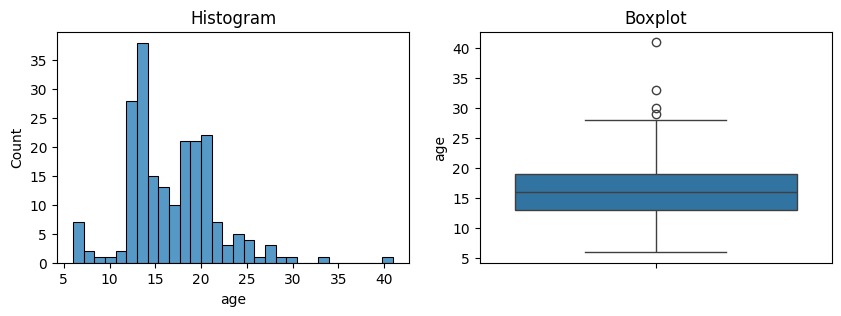

Skewness: 0.89375098722939
Kurtosis: 2.6925994766963353


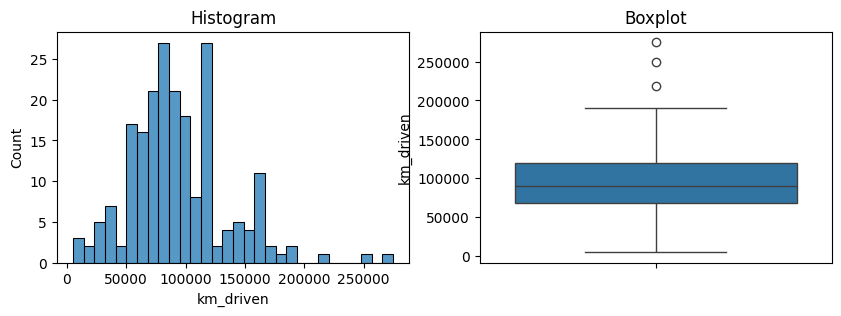

Skewness: 0.8927093488662923
Kurtosis: 1.9607335108304556


In [18]:
check_distribution_outliers(df.loc[df['mileage(km/ltr/kg)'].isna(),num_cols], ['age','km_driven'])

In [19]:
df = df.dropna(subset=['mileage(km/ltr/kg)']).reset_index(drop=True)

for i in df.columns:
    print(i, df[i].isna().sum())

name 0
selling_price 0
km_driven 0
fuel 0
seller_type 0
transmission 0
owner 0
mileage(km/ltr/kg) 0
engine 0
max_power 1
seats 0
age 0


In [20]:
df['manufacturer'] = df['name'].apply(lambda x:x.split(' ')[0])

## Encoding

In [74]:
nom_cols = ['fuel','seller_type']

ord_enc = OrdinalEncoder(categories=[['Test Drive Car','First Owner','Second Owner','Third Owner','Fourth & Above Owner']])
ohe_enc = OneHotEncoder(sparse_output=False)
bin_enc = LabelEncoder()

In [75]:
oh_encoded = ohe_enc.fit_transform(df[nom_cols])
one_hot_df = pd.DataFrame(oh_encoded, columns=ohe_enc.get_feature_names_out(nom_cols))

In [63]:
data = df.copy().reset_index(drop=True)
data['owner'] = ord_enc.fit_transform(df[['owner']])
data['transmission'] = bin_enc.fit_transform(df[['transmission']])
# data = pd.concat([data.drop(columns=nom_cols),pd.get_dummies(data[nom_cols]).astype('int')],axis=1)
data = pd.concat([data.drop(columns=nom_cols),one_hot_df.astype('int')],axis=1)
data.head()

c:\Users\grego\.conda\envs\torch_py310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,name,selling_price,km_driven,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,age,manufacturer,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer
0,Maruti Swift Dzire VDI,450000,145500,1,1.0,23.40,1248.0,74.00,5.0,10,Maruti,0,1,0,0,0,1,0
1,Skoda Rapid 1.5 TDI Ambition,370000,120000,1,2.0,21.14,1498.0,103.52,5.0,10,Skoda,0,1,0,0,0,1,0
2,Honda City 2017-2020 EXi,158000,140000,1,3.0,17.70,1497.0,78.00,5.0,18,Honda,0,0,0,1,0,1,0
3,Hyundai i20 Sportz Diesel,225000,127000,1,1.0,23.00,1396.0,90.00,5.0,14,Hyundai,0,1,0,0,0,1,0
4,Maruti Swift VXI BSIII,130000,120000,1,1.0,16.10,1298.0,88.20,5.0,17,Maruti,0,0,0,1,0,1,0


## Train-Test Split

In [36]:
x = data[data.columns.drop(['selling_price','name','manufacturer'])]
y = data['selling_price']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=123)
print(x_train.shape,x_test.shape)

(5374, 15) (1344, 15)


In [37]:
num_cols

['age', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'seats', 'max_power']

In [54]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
iqr_winsor = Winsorizer(capping_method='iqr',
                        tail='right',
                        # variables=num_cols.remove('seats'),
                        variables=[i for i in num_cols if i != "seats"],
                        missing_values='ignore')

std_scaler = StandardScaler()
rob_scaler = RobustScaler()
y_scaler = RobustScaler()

num_non_norm_cols = ['age', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'seats']

In [56]:
x_train[[i for i in num_cols if i != "seats"]] = iqr_winsor.fit_transform(x_train[[i for i in num_cols if i != "seats"]])
x_test[[i for i in num_cols if i != "seats"]] = iqr_winsor.transform(x_test[[i for i in num_cols if i != "seats"]])

x_train['max_power'] = imputer.fit_transform(x_train[['max_power']])

In [57]:
x_train.loc[4142]

km_driven                       100000.00
transmission                         1.00
owner                                2.00
mileage(km/ltr/kg)                  10.90
engine                             796.00
max_power                           81.83
seats                                8.00
age                                 22.00
fuel_CNG                             1.00
fuel_Diesel                          0.00
fuel_LPG                             0.00
fuel_Petrol                          0.00
seller_type_Dealer                   0.00
seller_type_Individual               1.00
seller_type_Trustmark Dealer         0.00
Name: 4142, dtype: float64

In [58]:
x_train['max_power'] = std_scaler.fit_transform(x_train[['max_power']])
x_test['max_power'] = std_scaler.transform(x_test[['max_power']])

x_train[num_non_norm_cols] = rob_scaler.fit_transform(x_train[num_non_norm_cols])
x_test[num_non_norm_cols] = rob_scaler.transform(x_test[num_non_norm_cols])

y_train = y_scaler.fit_transform(pd.DataFrame(y_train))
y_test = y_scaler.transform(pd.DataFrame(y_test))

## Modelling

In [59]:
model = LinearRegression()
model = model.fit(X=x_train,y=y_train)
model.coef_

array([[-0.23491362, -1.11354461, -0.04896066, -0.14522638,  0.07120546,
         0.40812742, -0.04324315, -0.57878409, -0.03925386,  0.17471431,
         0.10806551, -0.24352596,  0.27956349, -0.01387568, -0.26568781]])

In [41]:
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
r2(y_train,y_train_pred)

0.5447984007407477

In [38]:
ols_model = OLS(y_train,x_train)
results = ols_model.fit()

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     493.5
Date:                Tue, 24 Sep 2024   Prob (F-statistic):               0.00
Time:                        23:17:56   Log-Likelihood:                -6853.1
No. Observations:                5374   AIC:                         1.373e+04
Df Residuals:                    5360   BIC:                         1.383e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
km_driven                       -0.2349      0.022    -10.646      0.000      -0.278      -0.192
transmission                    -1.1135      0.048    -23.218      0.000      -1.208      -1.020
owner                           -0.0490      0.019     -2.622      0.009      -0.086      -0.012
mileage(km/ltr/kg)              -0.1452      0.030     -4.852      0.000      -0.204      -0.087
engine                           0.0712      0.027      2.643      0.008       0.018       0.124
max_power                        0.4081      0.022     18.855      0.000       0.366       0.451
seats                           -0.0432      0.017     -2.560      0.011      -0.076      -0.010
age                             -0.5788      0.028    -20.650      0.000      -0.634      -0.524
fuel_CNG                         0.5567      0.121      4.583      0.000       0.319       0.795
fuel_Diesel                      0.7707      0.053     14.676      0.000       0.668       0.874
fuel_LPG                         0.7040      0.146      4.815      0.000       0.417       0.991
fuel_Petrol                      0.3524      0.048      7.313      0.000       0.258       0.447
seller_type_Dealer               1.0742      0.057     18.718      0.000       0.962       1.187
seller_type_Individual           0.7807      0.052     14.906      0.000       0.678       0.883
seller_type_Trustmark Dealer     0.5289      0.164      3.231      0.001       0.208       0.850
==============================================================================
Omnibus:                     7493.255   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3866720.416
Skew:                           7.857   Prob(JB):                         0.00
Kurtosis:                     133.467   Cond. No.                     6.48e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.79e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [45]:
y_pred_ols = results.predict(x_test)

## Evaluation

In [60]:
y_test_inv = y_scaler.inverse_transform(y_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)
y_pred_ols_inv = y_scaler.inverse_transform(np.array(y_pred_ols).reshape(-1,1))

In [50]:
def evaluate_regression_results(y_true:np.array,y_pred:np.array):
    res_dict = {}
    res_dict['mae'] = mae(y_true,y_pred)
    res_dict['mse'] = mse(y_true,y_pred)
    res_dict['rmse'] = np.sqrt(res_dict['mse'])
    res_dict['r2'] = r2(y_true,y_pred)
    return res_dict

In [62]:
evaluate_regression_results(y_test_inv,y_pred_inv)

{'mae': 190812.94332732246,
 'mse': 163744276682.99167,
 'rmse': 404653.27959006047,
 'r2': 0.5386479173908305}

In [63]:
evaluate_regression_results(y_test_inv,y_pred_ols_inv)

{'mae': 190812.94332732237,
 'mse': 163744276682.99176,
 'rmse': 404653.2795900606,
 'r2': 0.5386479173908303}

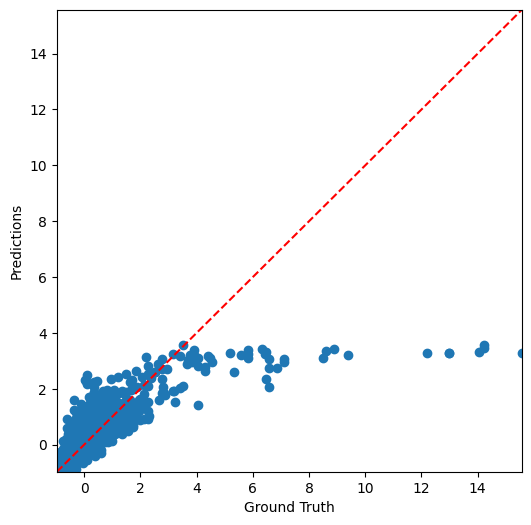

In [82]:
plt.figure(figsize=(6,6))
plt.subplot(1, 1, 1)
plt.scatter(y_test,y_pred)
plt.axline( (0,0),slope=1,linestyle='--',color='red')
plt.ylim(y_test.min(),y_test.max())
plt.xlim(y_test.min(),y_test.max())
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.show()

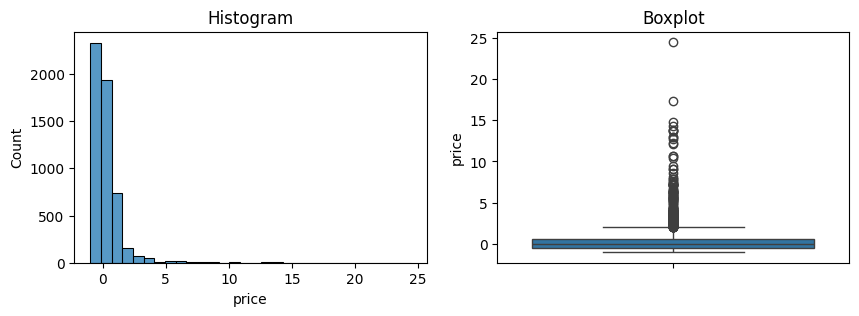

Skewness: 5.705825100082875
Kurtosis: 58.74228679363856


In [93]:
check_distribution_outliers(pd.Series(y_train.flatten()).to_frame('price'),columns=["price"])

See what happened? Most of the values are < 5! For the next step, we'll need an EDA **specifically** for the outliers

## Save as Pickle

In [76]:
exp_path = 'exp/03/'
os.makedirs(exp_path,exist_ok=True)

with open(os.path.join(exp_path,'y_scaler.pkl'), 'wb') as f:
  pickle.dump(y_scaler, f)

with open(os.path.join(exp_path,'model.pkl'), 'wb') as f:
  pickle.dump(model, f)

with open(os.path.join(exp_path,'std_scaler.pkl'), 'wb') as f:
  pickle.dump(std_scaler, f)

with open(os.path.join(exp_path,'rob_scaler.pkl'), 'wb') as f:
  pickle.dump(rob_scaler, f)

with open(os.path.join(exp_path,'imputer.pkl'), 'wb') as f:
  pickle.dump(imputer, f)

with open(os.path.join(exp_path,'winsorizer.pkl'), 'wb') as f:
  pickle.dump(iqr_winsor, f)

with open(os.path.join(exp_path,'ord_enc.pkl'), 'wb') as f:
  pickle.dump(ord_enc, f)

with open(os.path.join(exp_path,'bin_enc.pkl'), 'wb') as f:
  pickle.dump(bin_enc, f)

with open(os.path.join(exp_path,'ohe_enc.pkl'), 'wb') as f:
  pickle.dump(ohe_enc, f)

# Inference

In [40]:
exp_path = 'exp/03/'

with open(os.path.join(exp_path,'y_scaler.pkl'), 'rb') as f:
  y_scaler = pickle.load(f)

with open(os.path.join(exp_path,'model.pkl'), 'rb') as f:
  model = pickle.load(f)

with open(os.path.join(exp_path,'std_scaler.pkl'), 'rb') as f:
  std_scaler = pickle.load(f)

with open(os.path.join(exp_path,'rob_scaler.pkl'), 'rb') as f:
  rob_scaler = pickle.load(f)

with open(os.path.join(exp_path,'imputer.pkl'), 'rb') as f:
  imputer = pickle.load(f)

with open(os.path.join(exp_path,'winsorizer.pkl'), 'rb') as f:
  iqr_winsor = pickle.load(f)

with open(os.path.join(exp_path,'ord_enc.pkl'), 'rb') as f:
  ord_enc = pickle.load(f)

with open(os.path.join(exp_path,'bin_enc.pkl'), 'rb') as f:
  bin_enc = pickle.load(f)

with open(os.path.join(exp_path,'ohe_enc.pkl'), 'rb') as f:
  ohe_enc = pickle.load(f)

In [44]:
def make_predictions(df_in):
    df = df_in.copy().reset_index(drop=True)
    df['age'] = dt.now().year - df['year']
    df = df.drop(columns=['year'])

    nom_cols = ['fuel','seller_type']
    num_cols = ['age', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'seats', 'max_power']
    num_non_norm_cols = ['age', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'seats']

    oh_encoded = ohe_enc.transform(df[nom_cols])
    one_hot_df = pd.DataFrame(oh_encoded, columns=ohe_enc.get_feature_names_out(nom_cols))

    df.loc[:,'owner'] = ord_enc.transform(df[['owner']])
    df.loc[:,'transmission'] = bin_enc.transform(df[['transmission']])
    df = pd.concat([df.drop(columns=nom_cols),one_hot_df.astype('int')],axis=1)

    x = df[df.columns.drop(['selling_price','name','manufacturer'], errors='ignore')]
    x.loc[:,'max_power'] = imputer.transform(x[['max_power']])
    x.loc[:,[i for i in num_cols if i != "seats"]] = iqr_winsor.transform(x[[i for i in num_cols if i != "seats"]])
    # print(x.info())
   
    x.loc[:,'max_power'] = std_scaler.transform(x[['max_power']])

    x.loc[:,num_non_norm_cols] = rob_scaler.transform(x[num_non_norm_cols])

    y_pred = model.predict(x)

    return np.round(y_scaler.inverse_transform(y_pred)).flatten()
    
    

In [46]:
df = pd.read_csv('./Dataset/cardekho.csv')
df.head(6)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0
5,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,5.0


In [45]:
make_predictions(df.loc[:5].drop(columns=['selling_price']))

c:\Users\grego\.conda\envs\torch_py310\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\grego\AppData\Local\Temp\ipykernel_14188\3712060727.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.          0.          1.33333333  0.66666667  1.16666667 -0.5       ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x.loc[:,num_non_norm_cols] = rob_scaler.transform(x[num_non_norm_cols])
C:\Users\grego\AppData\Local\Temp\ipykernel_14188\3712060727.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.23492633  0.81783201  1.14496481  0.93232849  0.81783201 -0.408916  ]' has dty

array([344488., 587654., -48556., 335367., 116860., 520517.])